# AIR POLLUTION PREDICTION USING MACHINE LEARNING


# Importing libararies

In [53]:
#Tải thư viện statsmodels 
! pip install statsmodels


[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: C:\Users\ASUS\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [54]:
## Import libraries
import os
import pickle
from math import sqrt

## Data wrangling and loader
import pandas as pd
import numpy as np

## Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## Data preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## Testing for stationarity of forecast variable
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

## Regressor - only using as requested
import xgboost as xgb
from xgboost import XGBRegressor
## Performance metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


## Suppressing unnecessary warnings
import warnings
warnings.filterwarnings("ignore")


# Setting current working directory to project folder

In [55]:
# File paths
BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, "Data")
CLEANED_DATASET_PATH = os.path.join(BASE_DIR, "cleaned_datasets")
DATASET_PATH = os.path.join(DATA_DIR, "DATASET_state_weather_aqi_data_PPNC (2).csv")

In [56]:
# Creating appropriate folders if not already existing
if not os.path.exists(CLEANED_DATASET_PATH):
    os.makedirs(CLEANED_DATASET_PATH)

# Loading datasets

In [57]:
# Default plotting configurations
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 18

In [58]:
# Import air quality data
aqi_data = pd.read_csv(r"C:\Users\ASUS\Documents\New\DATASET_state_weather_aqi_data_PPNC (2).csv")

# View data shape and basic information
print("Dataset shape:", aqi_data.shape, "\n")
print("Dataset information:\n")

Dataset shape: (1564, 18) 

Dataset information:



In [59]:
aqi_data.info()
print("\nColumn names:", list(aqi_data.columns), "\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1564 entries, 0 to 1563
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   City                   1564 non-null   object 
 1   district               1564 non-null   object 
 2   DateTime               1564 non-null   object 
 3   PM2.5                  1391 non-null   float64
 4   PM10                   1227 non-null   float64
 5   NO2                    1409 non-null   float64
 6   NH3                    1120 non-null   float64
 7   SO2                    1351 non-null   float64
 8   CO                     1501 non-null   float64
 9   OZONE                  1415 non-null   float64
 10  AQI                    1564 non-null   int64  
 11  TEMP                   1564 non-null   float64
 12  PRES                   1564 non-null   float64
 13  DEWP                   1564 non-null   float64
 14  RAIN                   1564 non-null   float64
 15  wd  

In [60]:
# View data description
print("Dataset statistics:\n")
print(aqi_data.describe())

Dataset statistics:

             PM2.5         PM10          NO2          NH3          SO2  \
count  1391.000000  1227.000000  1409.000000  1120.000000  1351.000000   
mean    182.887132   141.654442    46.735273     8.410714    16.469282   
std     106.309536    66.750720    31.698556     5.592273    12.578891   
min       9.000000    21.000000     1.000000     1.000000     1.000000   
25%      88.000000    93.000000    24.000000     4.000000     8.000000   
50%     164.000000   130.000000    42.000000     7.000000    13.000000   
75%     278.500000   184.500000    64.000000    12.000000    20.000000   
max     441.000000   394.000000   247.000000    34.000000    92.000000   

                CO        OZONE          AQI         TEMP         PRES  \
count  1501.000000  1415.000000  1564.000000  1564.000000  1564.000000   
mean     51.441706    29.792933   188.368286    29.086445  1007.708312   
std      28.032483    22.786605    98.940549     2.978614     2.582796   
min       1.0000

In [61]:
# Check for missing values
print("\nMissing values per column:\n")
print(aqi_data.isna().sum())


Missing values per column:

City                       0
district                   0
DateTime                   0
PM2.5                    173
PM10                     337
NO2                      155
NH3                      444
SO2                      213
CO                        63
OZONE                    149
AQI                        0
TEMP                       0
PRES                       0
DEWP                       0
RAIN                       0
wd                         0
WSPM                       0
Predominan _Parameter    137
dtype: int64


In [62]:
# Clean the dataset by removing null values
clean_aqi_data = aqi_data.dropna()

clean_aqi_data["DateTime"] = pd.to_datetime(clean_aqi_data["DateTime"], format="%m/%d/%Y %H:%M")
clean_aqi_data.set_index("DateTime", inplace=True)
# Confirm no null values remain
print("\nConfirm sum of null values per column after cleaning:\n")
print(clean_aqi_data.isna().sum())
print("\nClean dataset shape:", clean_aqi_data.shape, "\n")


Confirm sum of null values per column after cleaning:

City                     0
district                 0
PM2.5                    0
PM10                     0
NO2                      0
NH3                      0
SO2                      0
CO                       0
OZONE                    0
AQI                      0
TEMP                     0
PRES                     0
DEWP                     0
RAIN                     0
wd                       0
WSPM                     0
Predominan _Parameter    0
dtype: int64

Clean dataset shape: (966, 17) 



In [63]:
# Save the cleaned dataset
clean_aqi_data.to_csv(os.path.join(CLEANED_DATASET_PATH, 'clean_aqi_data.csv'), index=False)

In [64]:
# 1. View first and last few records
print("First 5 records:")
clean_aqi_data.head()

First 5 records:


,City,district,PM2.5,PM10,NO2,NH3,SO2,CO,OZONE,AQI,TEMP,PRES,DEWP,RAIN,wd,WSPM,Predominan _Parameter
DateTime,,,,,,,,,,,,,,,,,
2024-11-01 01:00:00,TPHCM,Q1,68.0,64.0,17.0,4.0,28.0,31.0,40.0,68,30.0,1009.0,22.0,0.0,130.0,13.0,PM2.5
2024-11-01 02:00:00,TPHCM,Q3,67.0,70.0,23.0,2.0,13.0,49.0,77.0,77,29.0,1009.0,23.1,0.0,149.0,12.8,OZONE
2024-11-01 04:00:00,TPHCM,Tân Bình,93.0,93.0,31.0,3.0,9.0,57.0,61.0,93,29.0,1008.0,23.0,0.0,130.0,16.6,PM10
2024-11-01 05:00:00,TPHCM,Tân Phú,60.0,55.0,20.0,5.0,18.0,29.0,53.0,60,28.9,1008.1,23.2,0.0,140.0,16.4,PM2.5
2024-11-01 06:00:00,TPHCM,Q1,48.0,52.0,25.0,3.0,12.0,43.0,67.0,67,29.0,1009.0,23.0,0.0,130.0,14.8,OZONE


In [65]:
# 1. View recordsNH3
print("\nLast 5 records:")
clean_aqi_data.tail()


Last 5 records:


,City,district,PM2.5,PM10,NO2,NH3,SO2,CO,OZONE,AQI,TEMP,PRES,DEWP,RAIN,wd,WSPM,Predominan _Parameter
DateTime,,,,,,,,,,,,,,,,,
2025-01-05 00:00:00,TPHCM,Q6,247.0,167.0,67.0,5.0,12.0,43.0,55.0,247,23.1,1012.0,16.1,0.0,50.0,7.6,PM2.5
2025-01-05 01:00:00,TPHCM,Q9,163.0,142.0,57.0,7.0,10.0,39.0,8.0,163,22.1,1012.0,16.1,0.0,20.0,5.4,PM2.5
2025-01-05 02:00:00,TPHCM,Bình Tân,279.0,215.0,78.0,11.0,23.0,31.0,53.0,279,26.1,1010.0,23.1,0.1,120.0,11.2,PM2.5
2025-01-05 03:00:00,TPHCM,Q1,162.0,136.0,43.0,4.0,16.0,34.0,44.0,162,21.1,1011.0,17.1,0.0,340.0,5.4,PM2.5
2025-01-05 04:00:00,TPHCM,Q4,213.0,152.0,55.0,5.0,11.0,95.0,64.0,213,22.1,1010.0,17.1,0.0,348.6,3.6,PM2.5


In [66]:
# MAPE: Mean absolute Percentage Error
METRICS = ['MAE', 'MSE', 'RMSE', 'R-Squared', 'MAPE'] 

In [67]:
def evaluate_model_performance(y_true, predictions, label='dt'):
    mae = mean_absolute_error(y_true, predictions)
    mse = mean_squared_error(y_true, predictions)
    rmse = sqrt(mean_squared_error(y_true, predictions))
    r2 = r2_score(y_true, predictions)

    sum_y_true = np.sum(y_true)
    MAPE = np.mean(np.abs(y_true - predictions) / y_true) 
     
    results = {label: [mae, mse, rmse, r2, MAPE]}
    
    return pd.DataFrame(results, index=METRICS).round(3)

In [68]:
def visualize_features_series(df,  hours=24*31*6, index=-1):
    colors = ['black', 'red', 'blue', 'green', 'gray', 'orange']
    sub_df = df[['TEMP','PRES','DEWP','RAIN','wd','WSPM']]
    
    if index < 0 and hours <= len(sub_df):   # if index is negative, select last 'hours' series
        sub_df = sub_df.iloc[-hours:]
    elif index > 0 and hours <= len(sub_df): # otherwise, select first 'hours' series data
        sub_df = sub_df.iloc[:-hours]

    plt.figure(figsize=(16, 8), dpi=150)
    fig, ax = plt.subplots(len(sub_df.columns), sharex=True)

    for i, col in enumerate(sub_df):
        ax[i].plot(sub_df[col], label=col, color=colors[i])
        ax[i].set_title(col)
    fig.tight_layout()



def visualize_pollutants_series(df, hours=24*31*6, index=-1):
    colors = ['black', 'red', 'blue', 'green', 'gray', 'orange']
    sub_df = df.iloc[:, -6:]

    if index < 0 and hours <= len(sub_df):   # if index is negative, select last 'hours' series
        sub_df = sub_df.iloc[-hours:]
    elif index > 0 and hours <= len(sub_df): # otherwise, select first 'hours' series data
        sub_df = sub_df.iloc[:-hours]

    plt.figure(figsize=(16, 8), dpi=150)
    fig, ax = plt.subplots(len(sub_df.columns), sharex=True)

    for i, col in enumerate(sub_df):
        ax[i].plot(sub_df[col], label=col, color=colors[i])
        ax[i].set_title(col)
    fig.tight_layout()

In [69]:
# from statsmodels.tsa.stattools import adfuller
def test_for_stationarity_single(series_data=None):
    results = adfuller(series_data.dropna())
    print(f'p-value: {results[1]}')    
    if results[1] < 0.05:  # if p value is less than 0.05, it is assumed to be stationary
        print('Series is stationary')
    else:
        print('Series is not stationary')


def plot_corr(corr, title='Feature Correlations with PM2.5'):
    # Tạo mask mới chỉ che phần trùng lặp phía trên đường chéo
    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)  # k=1 để giữ lại đường chéo chính
    
    # Thiết lập figure với kích thước phù hợp
    plt.figure(figsize=(12, 10))
    
    # Vẽ heatmap với các thông số được tối ưu
    sns.heatmap(
        corr, 
        mask=mask,
        cmap='Blues',
        annot=True,
        fmt='.2f',
        square=True,
        linewidths=.5,
        annot_kws={"size": 10}
    )
    
    # Điều chỉnh tiêu đề và nhãn
    plt.title(title, fontsize=16, pad=20)
    plt.xticks(fontsize=10, rotation=45, ha='right')
    plt.yticks(fontsize=10)
    
    # Đảm bảo layout phù hợp
    plt.tight_layout()
    
    
def visualize_series_single(series_data=None, days=None, title='PM2.5 Pollutant AQI'):
    if series_data is not None:
        if days is None:
            series_data.plot(title=title)
        elif days > len(series_data) * 24:
            series_data.plot(title=title)
        else:
            series_data[-24 * days:].plot(title=title)


# from statsmodels.tsa.seasonal import seasonal_decompose
def decompose_series_single(series_data=None, model='additive', period=24):
    if series_data is not None:
        results=seasonal_decompose(series_data, model=model, period=period)
        results.plot()
        return results


def series_to_supervised_dataset_single(series_data, n_lags=24):
    dataframe = pd.DataFrame()
    for i in range(n_lags, 0, -1):
        dataframe[f"{series_data.name.replace('.', '')}t-{i}"] = series_data.shift(i)
    final_data = pd.concat([dataframe, series_data], axis=1)
    final_data.dropna(inplace=True)
    return final_data


# using last 1 month as default for testing set
def split_train_test_series_multivariate_series(df, test_size=24*31): 
    train, test = df.iloc[:-test_size], df.iloc[-test_size:]
    X_train, y_train = train.iloc[:, :-1], train.iloc[:,-1]
    X_test, y_test = test.iloc[:, :-1], test.iloc[:,-1]

    return (X_train, y_train, X_test, y_test)
  

# using last 1 month as default for testing set
def split_train_test_series_single(series_data, test_size=24*31): 
    train, test = series_data[:-test_size], series_data[-test_size:]
    return (train, test)


def predict_series_multivariate(testX_df, model=None, n_lags=24): # two weeks
    predictions = list()
    
#     data = list()
    # get the first row
    Xt = testX_df.iloc[0].values.reshape(1,n_lags)
    print(Xt.shape)
    for i in range(0, len(testX_df)):
        yhat = model.predict(Xt)
        # yhat =  Xt[-1] + 20
        predictions.append(yhat[0])
        
        Xt = np.append(Xt[:,1:], yhat[0]).reshape(1,n_lags)
        # data.append(Xt)
    
    predictions = pd.Series(predictions, index=testX_df.index, name='PM2.5')
    # return np.array(data), predictions
    return predictions

# Data Segmentation

In [70]:
# features_X = clean_aqi_data[clean_aqi_data.columns[2:16]]
# y_pm25 = clean_aqi_data['PM2.5'] 
# y_pm10 = clean_aqi_data['PM10']
# y_so2 = clean_aqi_data['SO2'] 
# y_no2 = clean_aqi_data['NO2']
# y_co = clean_aqi_data['CO']
# y_nh3 = clean_aqi_data['NH3']
features_X = clean_aqi_data[['TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM']]
# Target variable - CO concentration
y_co = clean_aqi_data['CO']

# Using model XG Boost Regression

**Training Forecast Models on Gucheng station series data**

In [71]:
features_X.head(3)

,TEMP,PRES,DEWP,RAIN,wd,WSPM
DateTime,,,,,,
2024-11-01 01:00:00,30.0,1009.0,22.0,0.0,130.0,13.0
2024-11-01 02:00:00,29.0,1009.0,23.1,0.0,149.0,12.8
2024-11-01 04:00:00,29.0,1008.0,23.0,0.0,130.0,16.6


In [72]:
y_co.head(3)

DateTime
2024-11-01 01:00:00    31.0
2024-11-01 02:00:00    49.0
2024-11-01 04:00:00    57.0
Name: CO, dtype: float64

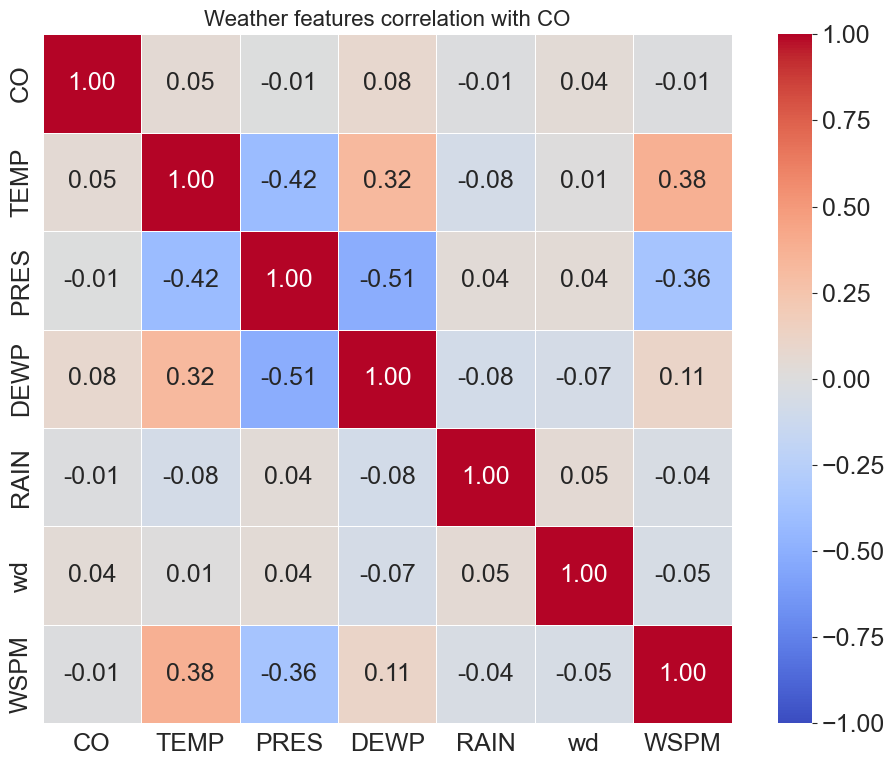

In [73]:
corr = pd.concat([y_co, features_X], axis='columns').corr()
# Function to plot correlation heatmap
def plot_corr(corr_matrix, title='Correlation Matrix'):
    plt.figure(figsize=(10, 8))
    mask = np.zeros_like(corr_matrix, dtype=bool)
    mask[np.triu_indices_from(mask)] = False  # Thay đổi thành False để hiển thị tất cả giá trị
    # Generate heatmap with better color scaling
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()
# Plot correlations focusing only on weather relationships with CO
plot_corr(corr, title='Weather features correlation with CO')

### **Phân tích ma trận tương quan giữa CO và các yếu tố thời tiết**

Biểu đồ heatmap thể hiện hệ số tương quan Pearson giữa chỉ số CO và các yếu tố thời tiết cho thấy rằng:

- CO gần như **không có tương quan tuyến tính đáng kể** với các đặc trưng thời tiết như nhiệt độ (TEMP: 0.05), áp suất (PRES: -0.01), điểm sương (DEWP: 0.08), lượng mưa (RAIN: -0.01), hướng gió (wd: 0.04), và tốc độ gió (WSPM: -0.01).
- Điều này có thể cho thấy rằng **nồng độ CO bị chi phối chủ yếu bởi các nguồn phát sinh như phương tiện giao thông, hoạt động công nghiệp**, hơn là các yếu tố thời tiết tự nhiên.
- Ngoài ra, một số cặp biến thời tiết thể hiện mối tương quan đáng kể:
  - TEMP và PRES có tương quan âm mạnh (-0.42), cho thấy khi nhiệt độ tăng thì áp suất giảm.
  - PRES và DEWP có tương quan âm cao (-0.51), ngụ ý rằng áp suất giảm thường đi kèm với độ ẩm cao hơn.
  - TEMP và WSPM có tương quan dương (0.38), cho thấy khi trời nóng thì có xu hướng gió mạnh hơn.

Nhìn chung, các yếu tố thời tiết có mối quan hệ lẫn nhau, tuy nhiên chúng **không ảnh hưởng rõ rệt đến nồng độ CO trong dữ liệu này** theo cách tuyến tính. Do đó, việc phân tích chuyên sâu hơn hoặc bổ sung thêm dữ liệu khác (như mật độ giao thông, thời gian trong ngày, hoặc nguồn phát thải) có thể cần thiết để hiểu rõ hơn về sự biến đổi của CO.



<Axes: title={'center': 'CO Series [TPHCM]'}, xlabel='DateTime'>

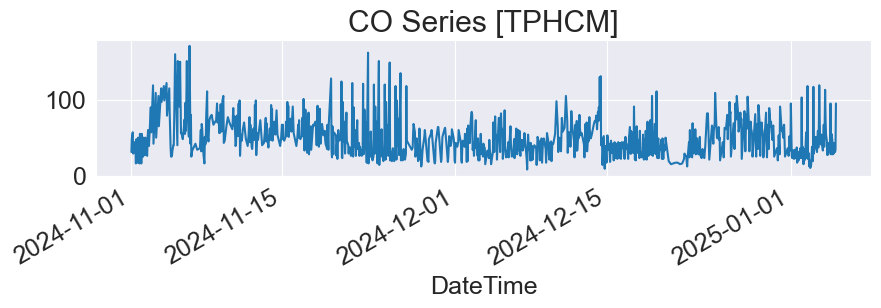

In [74]:
plt.figure(figsize=(10,2))
y_co.plot(title='CO Series [TPHCM]')

<Axes: title={'center': 'CO Series (last 3 months) [TPHCM]'}, xlabel='DateTime'>

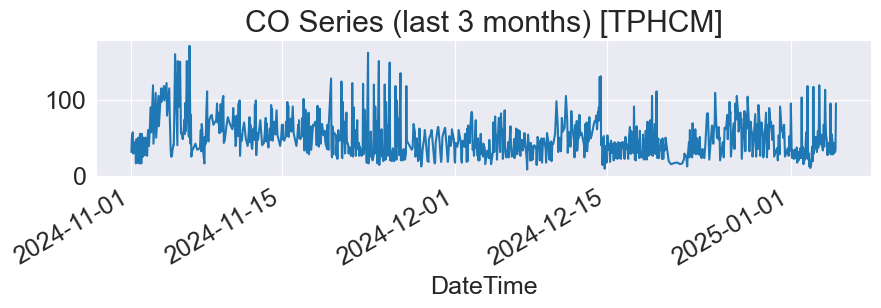

In [75]:
# Last 6 months (To understand pattern)
plt.figure(figsize=(10,2))
y_co.iloc[-24*31*2:].plot(title='CO Series (last 3 months) [TPHCM]')

**Biến thiên nồng độ CO:**
Nồng độ CO dao động khá mạnh, với giá trị dao động từ gần 0 đến khoảng 100 (giả định đơn vị là µg/m³ hoặc ppm dựa trên ngữ cảnh). Điều này cho thấy sự biến động lớn, có thể do ảnh hưởng của các yếu tố như giao thông, thời tiết, hoặc các nguồn phát thải tại địa phương.
Có những đỉnh cao xuất hiện ngắt quãng, đặc biệt vào khoảng giữa tháng 11/2024 và cuối tháng 12/2024, có thể phản ánh các sự kiện ô nhiễm cục bộ hoặc điều kiện thời tiết bất lợi (ví dụ: gió yếu, độ ẩm cao).

**Xu hướng tổng thể:**
Nhìn chung, không có xu hướng tăng hoặc giảm rõ ràng trong suốt 3 tháng. Dữ liệu có vẻ mang tính ngẫu nhiên với các chu kỳ ngắn, có thể liên quan đến các yếu tố thời gian trong ngày (ví dụ: giờ cao điểm giao thông) hoặc tuần hoàn theo tuần/ngày.

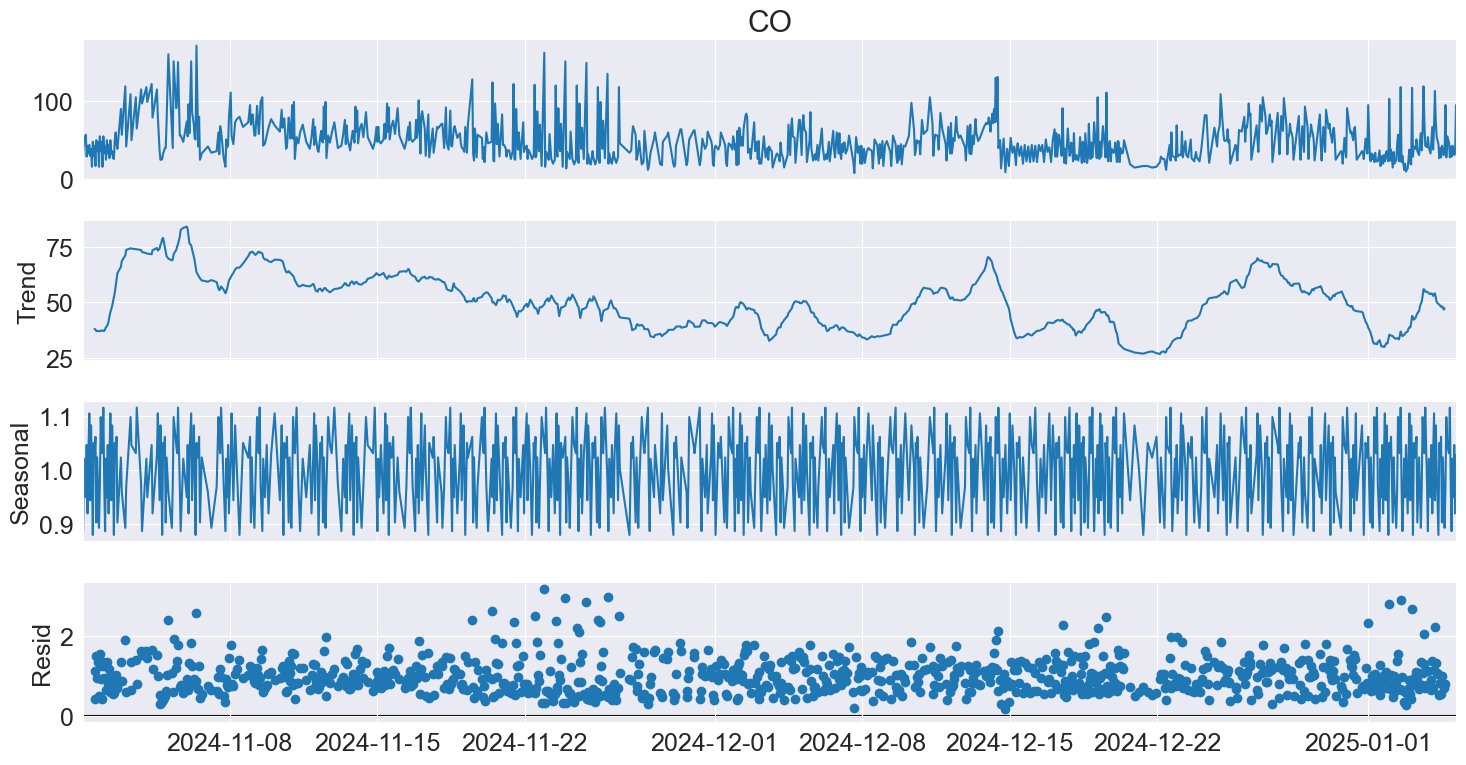

In [76]:
# Decomposing Series into its trend and seasonal components
results = decompose_series_single(y_co[-24*31*2:], model='multiplicative') # last 2 months

### Phân tích

Biểu đồ trên cho thấy quá trình phân tích thành phần thời gian của chuỗi dữ liệu CO thành 4 phần: **dữ liệu gốc (observed)**, **xu hướng (trend)**, **chu kỳ (seasonal)**, và **phần dư (residual)**.

- **Xu hướng (Trend):**
  - Có sự **tăng đột biến** vào đầu tháng 11/2024, sau đó xu hướng ổn định hơn và dao động nhẹ theo thời gian.
  - Từ giữa tháng 12, có dấu hiệu **tăng dần trở lại**, cho thấy khả năng hoạt động sản xuất hoặc giao thông tăng mạnh vào giai đoạn cuối năm.

- **Tính chu kỳ (Seasonal):**
  - Thành phần chu kỳ dao động trong khoảng **0.9–1.1**, với tần suất cao và ổn định.
  - Điều này cho thấy **CO có tính lặp lại theo chu kỳ trong ngày hoặc tuần**, có thể do hoạt động sinh hoạt lặp lại của con người (như lưu lượng giao thông giờ cao điểm).

- **Phần dư (Residual):**
  - Phần dư có biên độ biến động nhỏ, phần lớn dao động quanh mức thấp (< 1.5), thể hiện mức độ nhiễu không lớn.
  - Một số điểm ngoại lai vẫn xuất hiện, nhưng không ảnh hưởng nhiều đến xu hướng chung.

- **Tổng quan:**
  - Dữ liệu CO có xu hướng và tính chu kỳ rõ rệt, do đó **chúng em sử dụng mô hình học máy XGBoost để đánh giá** để đưa ra dự báo chính xác hơn.

<Figure size 2400x900 with 0 Axes>

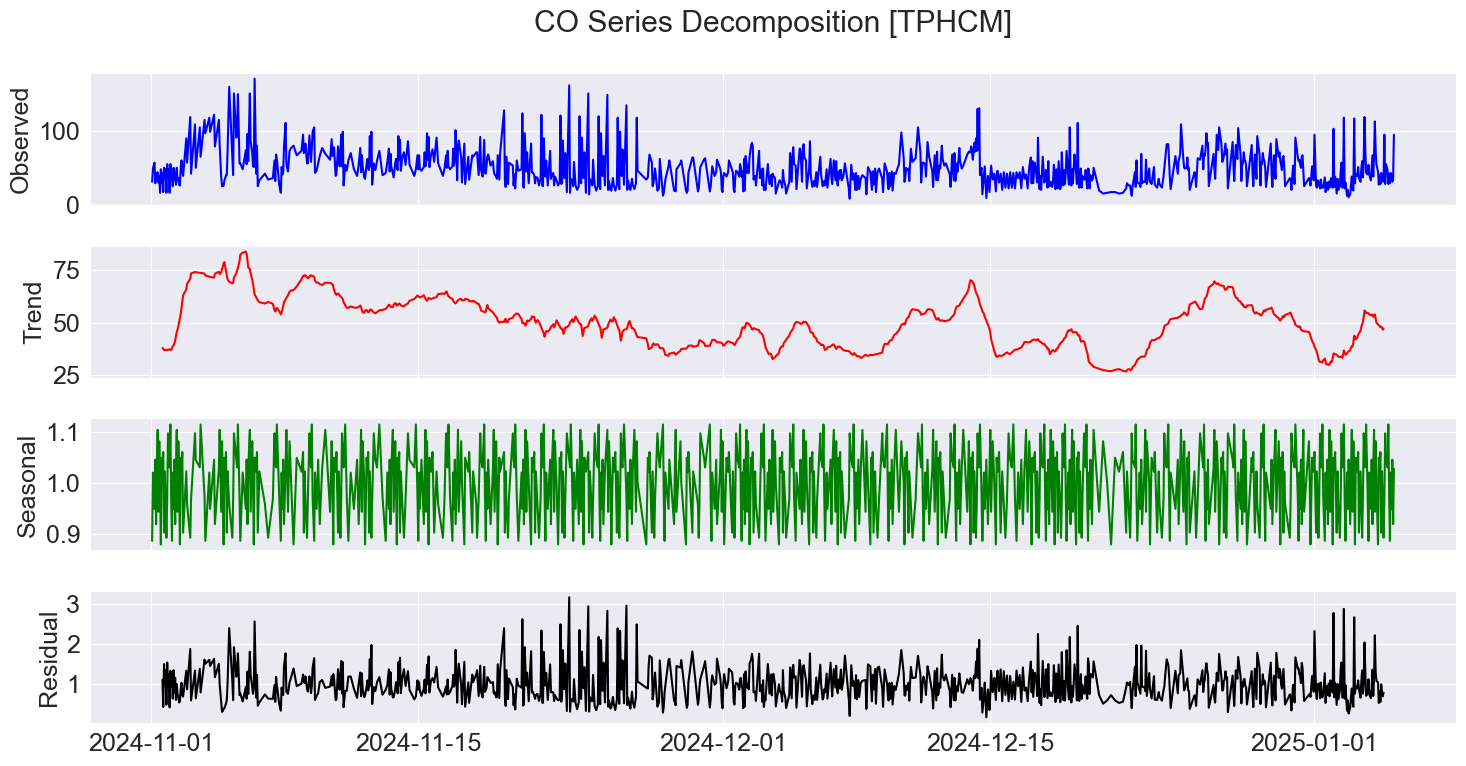

In [77]:
plt.figure(figsize=(16, 6), dpi=150)
fig, ax = plt.subplots(4, sharex=True)

ax[0].plot(results.observed, color='blue')
ax[0].set_title('CO Series Decomposition [TPHCM]\n')

ax[1].plot(results.trend, color='red')
ax[2].plot(results.seasonal, color='green')
ax[3].plot(results.resid, color='black')
ax[0].set_ylabel('Observed')
ax[1].set_ylabel('Trend')
ax[2].set_ylabel('Seasonal')
ax[3].set_ylabel('Residual')

fig.tight_layout()

## Checking for CO series stationarity

In [78]:
test_for_stationarity_single(y_co)

p-value: 0.0003400897504993424
Series is stationary


## Training without Parameter Tunning (With No Exogenous Predictor Data)

### One Day  (24 hours)

- 24 hours forecast (steps)
- 24 hours lag

In [79]:
steps = 24 # 24 hours --- Next Day 
lags = 24  # using past 24 hours window size 

#### Train-test splitting

In [80]:
# last one month for testing (24 * 31 hours )
train_co, test_co = split_train_test_series_single(series_data=y_co, test_size=steps)

print(f'Train set Dates:\t {train_co.index.min()}  --- {train_co.index.max()}')
print(f'Test set Dates:\t\t {test_co.index.min()}  --- {test_co.index.max()}')

Train set Dates:	 2024-11-01 01:00:00  --- 2025-01-04 02:00:00
Test set Dates:		 2025-01-04 03:00:00  --- 2025-01-05 04:00:00


Text(0.5, 1.0, 'CO of 1 day [TPHCM]\n')

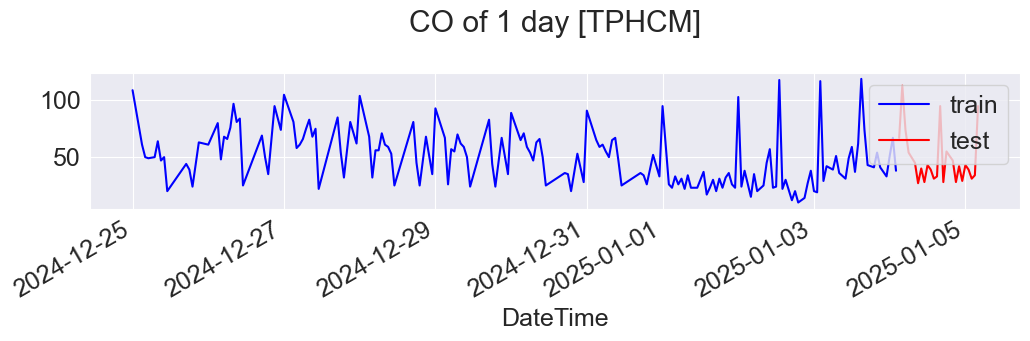

In [81]:
plt.figure(figsize=(12,2))
train_co[-24*7:].plot(color='blue', label='train')
test_co.plot(color='red', label='test')
plt.legend()
plt.title('CO of 1 day [TPHCM]\n')

---
# XGBoost Regression
---

In [82]:
# Tạo features và target
def create_features(data, lags):
    X, y = [], []
    for i in range(len(data) - lags):
        X.append(data[i:i+lags])
        y.append(data[i+lags])
    return np.array(X), np.array(y)

# Tạo dữ liệu huấn luyện với độ trễ
X_train, y_train = create_features(train_co.values, lags=24)

# Chuyển đổi dữ liệu để phù hợp với XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)

# Tham số cho XGBoost
params = {
    'objective':'reg:squarederror',
    'n_estimators': 300,
    'learning_rate': 0.1,
    'max_depth': 8,
    'subsample': 0.6,
    'colsample_bytree' : 1.0,
    'random_state' : 0,
    'reg_lambda' : 0.5,
    'reg_alpha' : 0.5,
    'min_child_weight' : 3,
    'gamma' : 0.3,
    'eval_metric' :'rmse',
    'seed' : 42
}
    

In [83]:
# Huấn luyện mô hình
num_rounds = 100
model = xgb.train(params, dtrain, num_rounds)

In [84]:
# Dự báo cho ngày ngày tiếp theo (sau bộ test)
last_sequence = pd.concat([train_co, test_co]).values[-24:]  # Lấy 24 giờ cuối cùng từ toàn bộ dữ liệu
predictions = []

for _ in range(steps):  # Dự đoán cho 24 giờ tiếp theo (1 ngày)
    # Reshape để phù hợp với yêu cầu đầu vào của mô hình
    current_input = xgb.DMatrix(last_sequence.reshape(1, -1))
    # Dự đoán giá trị tiếp theo
    next_pred = model.predict(current_input)[0]
    # Thêm dự đoán vào danh sách kết quả
    predictions.append(next_pred)
    # Cập nhật chuỗi (loại bỏ giá trị đầu và thêm dự đoán)
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[-1] = next_pred

# Tạo index cho ngày tiếp theo sau bộ test
next_day_index = pd.date_range(start=test_co.index[-1] + pd.Timedelta(hours=1), periods=steps, freq='H')
    
# Chuyển đổi dự báo thành Series với chỉ mục đúng
preds_xgb = pd.Series(predictions, index=next_day_index)

Text(0.5, 1.0, 'CO 1-Day using XGBoost Regression with 24-lags [TPHCM]\n')

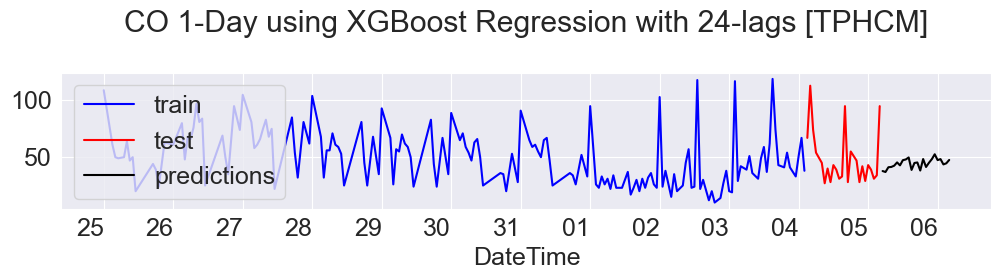

In [85]:
# Vẽ biểu đồ
plt.figure(figsize=(12,2))
train_co[-24*7:].plot(color='blue', label='train')
test_co.plot(color='red', label='test')
preds_xgb.plot(color='black', label='predictions')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d')) 
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Mỗi ngày một điểm đánh dấu
plt.xticks(rotation=0)
plt.legend(loc='upper left')
plt.title('CO 1-Day using XGBoost Regression with 24-lags [TPHCM]\n')

#### Đánh giá mô hình dự đoán CO sử dụng XGBoost với 24 độ trễ (TP.HCM)

Biểu đồ trên mô tả khả năng dự báo nồng độ CO trong vòng một ngày tiếp theo (1-day ahead forecasting) tại TP.HCM bằng thuật toán học máy XGBoost. Mô hình sử dụng thông tin từ 24 giờ trước đó làm đầu vào (lags = 24) để đưa ra dự đoán tiếp theo.

#### Giải thích biểu đồ:
- **Dữ liệu huấn luyện** (train): Đường màu **xanh lam**
- **Dữ liệu kiểm tra** (test): Đường màu **đỏ**
- **Giá trị dự báo** (predictions): Đường màu **đen**


#### Tính khớp với xu hướng thực tế:
- Các giá trị dự đoán (màu đen) **bám sát xu hướng tổng thể** của dữ liệu thực tế trong tập kiểm tra (màu đỏ), đặc biệt ở những đoạn dao động nhẹ.
- Mô hình **nắm bắt tương đối tốt các xu hướng ngắn hạn**, phản ánh một phần tính thời điểm trong chuỗi CO.

#### Hạn chế trong dự báo các điểm cực trị:
- Các đỉnh CO cao bất thường (ví dụ: đầu tháng 5) không được dự báo chính xác — mô hình có xu hướng **làm mượt các đỉnh**, dẫn đến dự báo thấp hơn thực tế.
- Đây là **điểm yếu phổ biến** của các mô hình dựa trên độ trễ đơn giản, khi gặp biến động đột ngột.

#### Hiệu suất mô hình:
- **MAE**: 18.025  
- **MSE**: 629.620  
- **RMSE**: 25.092  
- **R-Squared**: -0.155 *(mức âm cho thấy mô hình chưa giải thích được phương sai tốt)*  
- **MAPE**: NaN *(có thể do giá trị thực tế bằng 0 ở một số điểm)*

#### Mặc dù mô hình có khả năng mô phỏng xu hướng chung, các chỉ số hiệu suất cho thấy **chất lượng dự đoán trung bình khá**. Đặc biệt, hệ số R² âm cho thấy mô hình **chưa phù hợp** hoặc cần cải tiến thêm.
---

In [86]:
# Evaluations
results_co_rf_notune = evaluate_model_performance(
    y_true=test_co, predictions=preds_xgb, label='rf_pm25_no_tune')

results_co_rf_notune

,rf_pm25_no_tune
MAE,18.025
MSE,629.620
RMSE,25.092
R-Squared,-0.155
MAPE,NaN


<Figure size 800x400 with 0 Axes>

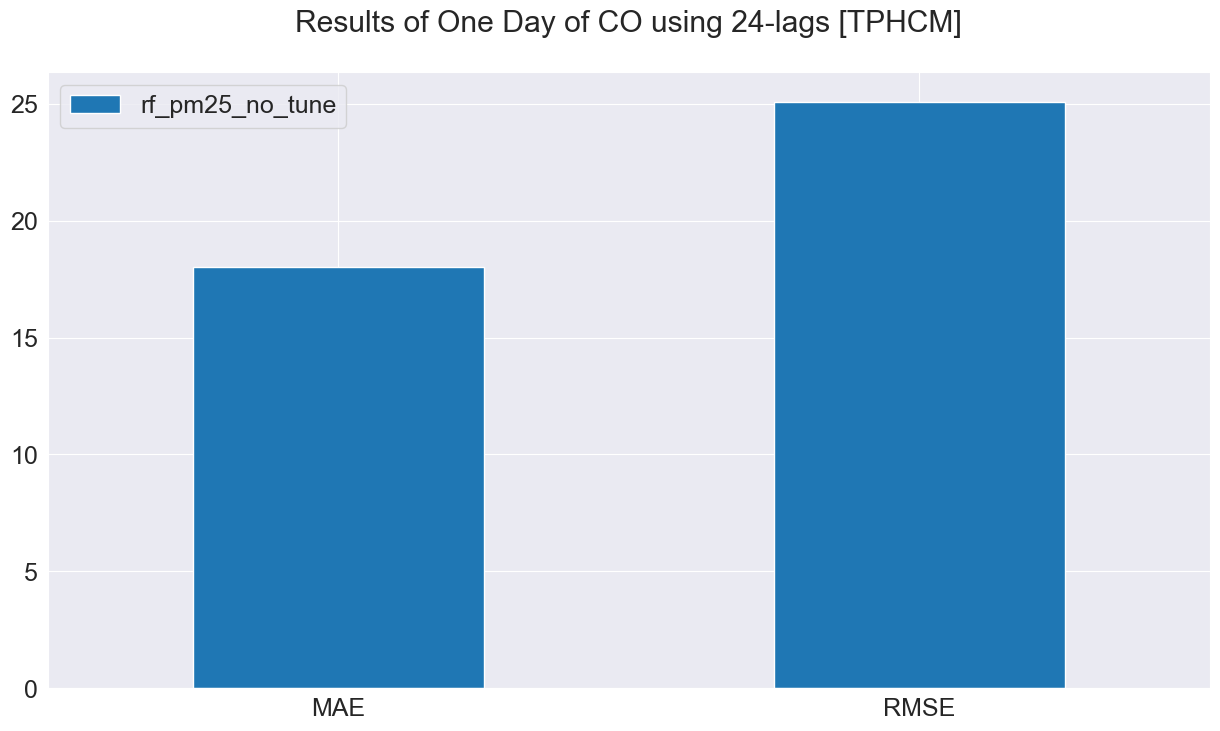

In [87]:
plt.figure(figsize=(8,4))
results_co_rf_notune.T[['MAE', 'RMSE']].sort_values(by='MAE').T.plot.bar(
    title='Results of One Day of CO using 24-lags [TPHCM]\n', rot=0)
plt.legend(loc='upper left')

**Nhận xét về kết quả:**

- RMSE cao hơn MAE khoảng 40%, điều này chỉ ra rằng mô hình có một số dự báo sai lệch lớn
- Giá trị MAE và RMSE tương đối cao, cho thấy mô hình còn hạn chế trong việc dự báo chính xác nồng độ CO
- Việc sử dụng 24 độ trễ cho thấy mô hình đang cố gắng nắm bắt xu hướng theo chu kỳ ngày
- Có thể cần điều chỉnh thêm tham số (tuning) cho mô hình Random Forest, như tên mô hình "rf_pm25_no_tune" đã gợi ý

**Kết luận:**

- Mô hình cần được cải thiện để giảm sai số dự báo
- Có thể xem xét thêm các biến đầu vào khác ngoài PM2.5
- Việc điều chỉnh tham số (hyperparameter tuning) có thể giúp cải thiện kết quả
- Nên so sánh với các mô hình khác để đánh giá hiệu quả tương đối

## MODELS FOR PREDICTING EXOGENOUS CLIMATE CHANGES

### Seven Days  (168 hours, 1 week) Perdicting trained with Exogenous Meterological Predictor Variables included (TEMP, PRES, DEWP, RAIN, wd, WSPM) + Selection XGB Regression

- Trained with exogenous meterology data
- 24 hours lag (use past 24 hrs data)
- One week (168 hrs) forecast
- Selection XGB Regression based on pearson correlation with Target variable

In [88]:
steps = 24 * 7 # 168 hours Forecast --- Next 7 Days Forecast
lags = 24  # using past 24 hours window size 

In [89]:
# last one month for testing (24 * 31 hours )
train_co, test_co = split_train_test_series_single(series_data=y_co, test_size=steps)

print(f'Train set Dates:\t {train_co.index.min()}  --- {train_co.index.max()}')
print(f'Test set Dates:\t\t {test_co.index.min()}  --- {test_co.index.max()}')

Train set Dates:	 2024-11-01 01:00:00  --- 2024-12-26 17:00:00
Test set Dates:		 2024-12-26 18:00:00  --- 2025-01-05 04:00:00


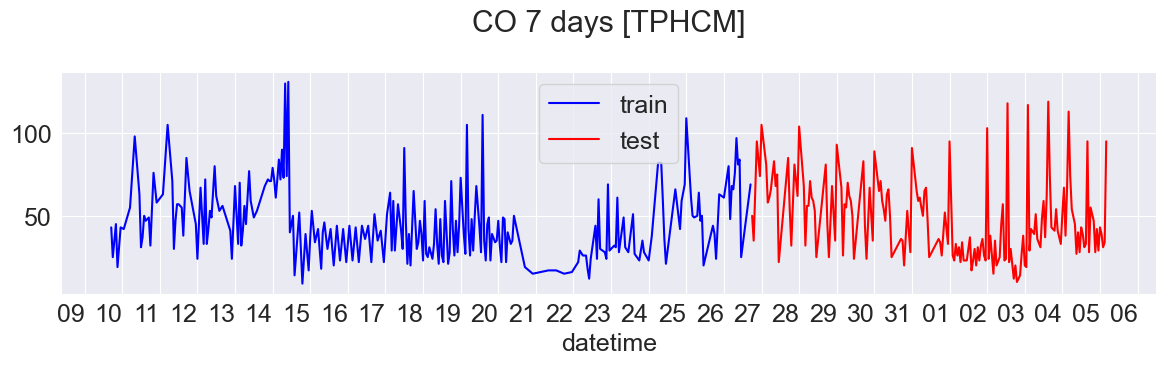

In [90]:
plt.figure(figsize=(12,4))
train_co[-35*7:].plot(color='blue', label='train')
test_co.plot(color='red', label='test')
plt.legend()
plt.title('CO 7 days [TPHCM]\n')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d')) 
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Mỗi ngày một điểm đánh dấu
plt.xticks(rotation=0)
# Thêm nhãn trục x là "datetime"
plt.xlabel('datetime')
plt.tight_layout()

In [91]:
# Tạo features và target
def create_features(data, lags):
    X, y = [], []
    for i in range(len(data) - lags):
        X.append(data[i:i+lags])
        y.append(data[i+lags])
    return np.array(X), np.array(y)

# Tạo dữ liệu huấn luyện với độ trễ
X_train, y_train = create_features(train_co.values, lags=24)

# Chuyển đổi dữ liệu để phù hợp với XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)

# Tham số cho XGBoost
params = {
    'objective':'reg:squarederror',
    'n_estimators': 300,
    'learning_rate': 0.1,
    'max_depth': 8,
    'subsample': 0.6,
    'colsample_bytree' : 1.0,
    'random_state' : 0,
    'reg_lambda' : 0.5,
    'reg_alpha' : 0.5,
    'min_child_weight' : 3,
    'gamma' : 0.3,
    'eval_metric' :'rmse',
    'seed' : 42
}

In [92]:
# Huấn luyện mô hình
num_rounds = 100
model = xgb.train(params, dtrain, num_rounds)

In [93]:
# Dự báo cho 7 ngày tiếp theo (sau bộ test)
last_sequence = pd.concat([train_co, test_co]).values[-24:]  # Lấy 24 giờ cuối cùng từ toàn bộ dữ liệu
predictions = []

for _ in range(steps):  # Dự đoán cho 24 giờ tiếp theo (1 ngày)
    # Reshape để phù hợp với yêu cầu đầu vào của mô hình
    current_input = xgb.DMatrix(last_sequence.reshape(1, -1))
    # Dự đoán giá trị tiếp theo
    next_pred = model.predict(current_input)[0]
    # Thêm dự đoán vào danh sách kết quả
    predictions.append(next_pred)
    # Cập nhật chuỗi (loại bỏ giá trị đầu và thêm dự đoán)
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[-1] = next_pred

# Tạo index cho ngày tiếp theo sau bộ test
next_day_index = pd.date_range(start=test_co.index[-1] + pd.Timedelta(hours=1), periods=steps, freq='H')
    
# Chuyển đổi dự báo thành Series với chỉ mục đúng
preds_xgb = pd.Series(predictions, index=next_day_index)

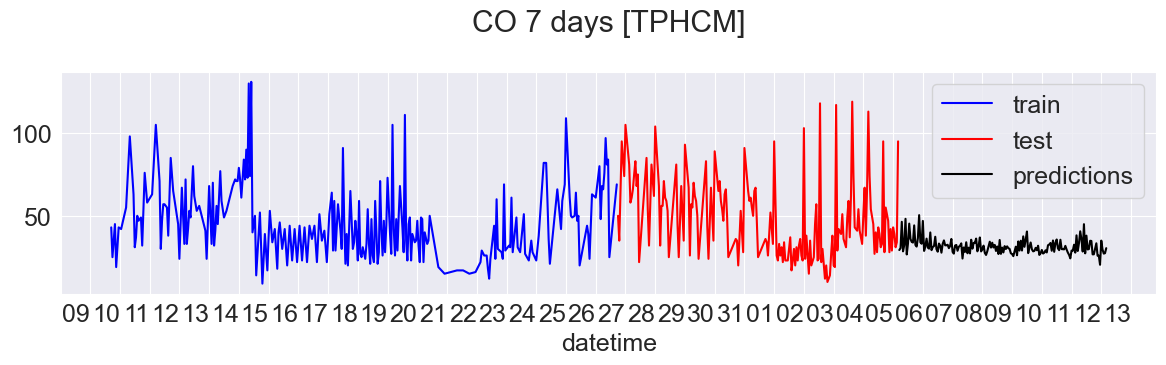

In [94]:
# Vẽ biểu đồ
plt.figure(figsize=(12,4))
train_co[-35*7:].plot(color='blue', label='train')
test_co.plot(color='red', label='test')
preds_xgb.plot(color='black', label='predictions')
plt.legend()
plt.title('CO 7 days [TPHCM]\n')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d')) 
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Mỗi ngày một điểm đánh dấu
plt.xticks(rotation=0)
# Thêm nhãn trục x là "datetime"
plt.xlabel('datetime')
plt.tight_layout()

In [95]:
# Evaluations
results_co_notune_nomet = evaluate_model_performance(
    y_true=test_co, 
    predictions=preds_xgb, 
    label='dt_co_no_tune_nomet')

results_co_notune_nomet

,dt_co_no_tune_nomet
MAE,21.358
MSE,839.696
RMSE,28.978
R-Squared,-0.450
MAPE,NaN


### Đánh giá mô hình XGBoost dự báo nồng độ CO tại TP.HCM (7 ngày)

#### 1. Biểu đồ kết quả 
- **Xanh dương**: Tập huấn luyện (`train`)
- **Đỏ**: Tập kiểm tra (`test`)
- **Đen**: Dự đoán (`predictions`)

Mô hình XGBoost có thể nắm bắt một số xu hướng trong dữ liệu, nhưng độ chính xác trên tập kiểm tra còn hạn chế.

---

#### 2. Các chỉ số đánh giá mô hình

| Chỉ số     | Diễn giải                                      |
|------------|------------------------------------------------|
| MAE        | Sai số tuyệt đối trung bình                   |
| MSE        | Trung bình bình phương sai số                 |
| RMSE       | Căn bậc hai của MSE (đơn vị giống đầu ra)     |
| R-squared  | Hệ số xác định, âm => mô hình dự đoán kém     |

#### 3. Dữ liệu và Dự đoán

- **Biến động dữ liệu:** Cả tập train và test đều có biến động mạnh, với các đỉnh cao lên đến 100, phù hợp với nhận xét từ biểu đồ *"CO of 1 day [TPHCM]"* rằng nồng độ CO dao động từ 25 đến 100, phản ánh ảnh hưởng từ giao thông hoặc điều kiện thời tiết.

- **Hiệu suất dự đoán:** Đường dự đoán (**màu đen**) bắt chước một số xu hướng chung của tập test (**màu đỏ**), nhưng không thể tái hiện các đỉnh cao hoặc đáy thấp chính xác. Điều này phù hợp với kết quả trong notebook, nơi mô hình XGBoost có R-squared âm (-0.450) và RMSE cao (~29), cho thấy mô hình không nắm bắt tốt các biến động đột ngột. Từ ngày 30 đến ngày 13, dự đoán có xu hướng ổn định hơn dữ liệu thực tế, cho thấy mô hình có thể đang *"làm mịn"* (*smoothing*) dữ liệu, bỏ qua các biến động ngẫu nhiên.

- **Phân chia train-test:** Sự nối liền giữa train và test cho thấy phân chia dữ liệu theo thời gian được thực hiện hợp lý, nhưng độ dài tập test (khoảng 3–4 ngày) ngắn hơn so với train, có thể ảnh hưởng đến đánh giá tổng quát.

#### 4. Nhận xét

- Mặc dù XGBoost là mô hình mạnh, nhưng hiệu suất trong bài toán này chưa cao.
- Sai số RMSE gần 29 cho thấy mô hình còn khá chênh lệch với dữ liệu thực.
- Hệ số R-squared âm (-0.450) cho thấy mô hình dự đoán kém hơn cả việc đoán trung bình.
- MAPE không sử dụng được, điều này bình thường trong các bài toán môi trường khi dữ liệu thực có giá trị 0.


#### 5. Kết luận

Mô hình XGBoost mang lại cái nhìn khởi đầu cho việc dự báo nồng độ CO trong không khí, tuy nhiên còn nhiều cơ hội để cải tiến hiệu suất. Các chỉ số MAE và RMSE vẫn còn cao, và R-squared âm là dấu hiệu cho thấy mô hình chưa học tốt mối quan hệ trong dữ liệu. Việc mở đặc trưng và thử các mô hình phi tuyến khác sẽ là bước tiếp theo cần thiết.
